# VAE

In [59]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [60]:
# download datasets

# you can also try transforms.ToTensor() + transforms.Normalize(mean, std) with mean = 0.5, std = 0.5, BUT if you do so, instead of nn.Sigmoid() in the model use nn.Tanh()
transform = transforms.ToTensor()

# download data for training
mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

In [61]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the conv features to feed them into the linear layers
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim * 2)  # We need 2 * latent_dim for mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # Unflatten to bring back into image dimensions for conv layers
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Sigmoid because MNIST is between [0, 1]
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x_encoded = self.encoder(x)
        mu, log_var = x_encoded.chunk(2, dim=-1)  # Split the encoded values into mu and log_var components
        
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_var

# Loss function for VAE
def vae_loss(reconstructed_x, x, mu, logvar):
    x = x.view(-1, 1, 28, 28)
    reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)

    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [66]:
device = 'mps'

latent_dim = 20
conv_vae = ConvVAE(latent_dim).to(device)

optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
mnist_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

# Training loop
epochs = 10
for epoch in tqdm(range(epochs)):
    loss = 0
    for batch_idx, (data, _) in enumerate(mnist_loader):
        # Move data to the device
        data = data.to(device)

        # Forward pass
        reconstructed_images, mu, logvar = conv_vae(data)

        # Compute loss
        loss = vae_loss(reconstructed_images, data, mu, logvar)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch_idx % 100 == 0:
        #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(mnist_loader.dataset)} "
        #           f"({100. * batch_idx / len(mnist_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")
    print(f'Epoch {epoch}, Loss: {loss}')

    # Perform any validation/testing you want to do at the end of each epoch

# Save the trained model
torch.save(conv_vae.state_dict(), 'conv_vae_mnist.pth')

print("Training complete")

 10%|█         | 1/10 [00:24<03:37, 24.15s/it]

Epoch 0, Loss: 3497.14990234375


 20%|██        | 2/10 [00:47<03:10, 23.83s/it]

Epoch 1, Loss: 3385.83837890625


 30%|███       | 3/10 [01:11<02:46, 23.78s/it]

Epoch 2, Loss: 3356.94775390625


 40%|████      | 4/10 [01:35<02:23, 23.86s/it]

Epoch 3, Loss: 3194.5419921875


 50%|█████     | 5/10 [01:58<01:58, 23.62s/it]

Epoch 4, Loss: 3400.082763671875


 60%|██████    | 6/10 [02:22<01:34, 23.54s/it]

Epoch 5, Loss: 3318.3828125


 70%|███████   | 7/10 [02:45<01:10, 23.44s/it]

Epoch 6, Loss: 2862.36572265625


 80%|████████  | 8/10 [03:09<00:47, 23.58s/it]

Epoch 7, Loss: 3266.5400390625


 90%|█████████ | 9/10 [03:32<00:23, 23.48s/it]

Epoch 8, Loss: 3266.679931640625


100%|██████████| 10/10 [03:55<00:00, 23.59s/it]

Epoch 9, Loss: 2921.112060546875
Training complete


# TRAIN AND TEST VAE

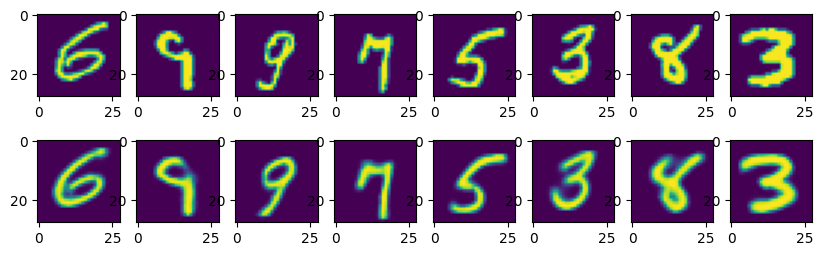

In [132]:
# Assuming 'test_data' is your MNIST test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

conv_vae.to('cpu')

data = torch.Tensor(next(iter(test_loader))[0]).to('cpu')


# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = conv_vae(data)

recov = []
origin = []
for i in range(8):
  origin.append(data[i].reshape(28,28))
  recov.append(reconstructed_images[i].reshape(28,28))

fig, ax = plt.subplots(nrows=2, ncols =8, figsize=(10,3))

for i in range(8):
  ax[0,i].imshow(origin[i].squeeze())
  ax[1,i].imshow(recov[i])

In [21]:
activations_encoder = {}

def get_activation(name, activations):
    def hook(model, input, output):
        if len(activations[name]) == 0:
            activations[name] = output.detach()
        else:
            activations[name].append
    return hook


model.encoder[0].register_forward_hook(get_activation('layer1', activations_encoder))
model.encoder[2].register_forward_hook(get_activation('layer2', activations_encoder))
model.encoder[4].register_forward_hook(get_activation('layer3', activations_encoder))
model.encoder[6].register_forward_hook(get_activation('layer4', activations_encoder))

In [ ]:
model(test_data[0][0].reshape(-1, 28 * 28))

In [23]:
activations_encoder

{'layer1': tensor([[-0.8404, -0.8353, -0.6566, -0.7928, -1.0579, -7.5049, -4.3912,  0.6749,
          -3.1447,  0.2464, -0.9858, -0.7052, -0.3106, -1.0848, -0.5587, -1.0955,
          -0.5263, -0.8815, -1.3998, -0.5129, -0.5313, -3.3016, -0.6598, -3.1067,
          -1.1738, -0.7433, -1.0330, -1.1691, -0.6232, -0.7744,  2.0290, -0.6548,
          -0.6705, -0.8278, -0.6767, -0.5596, -0.8472, -0.7249,  0.0413, -3.6198,
          -0.6653, -2.1471, -0.7490,  6.5004, -0.3174, -2.0665, -2.2898, -2.6311,
          -1.9783, -2.1610, -1.0544, -2.3906, -0.6267, -0.7098, -1.1075, -0.5457,
          -2.0886,  3.3775, -0.6678,  2.3714, -0.8041,  0.3034, -0.6791, -2.6767,
          -4.9594, -0.6331, -1.6381,  2.9677, -0.6015, -0.7201, -2.4860, -4.6381,
           2.7793, -1.5879, -0.5067,  2.1426, -1.9324, -5.0799, -6.2833,  0.1180,
          -0.4636, -2.6810,  0.2665, -0.6305, -0.8812, -1.1128, -0.5625, -0.5543,
          -0.8767, -0.7316, -0.7681, -3.3137, -0.4519, -0.4189, -0.8815, -0.6987,
      